In [177]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import os 
import time
from tqdm import tqdm
import matplotlib.pyplot as plt 
from matplotlib.image import imread
from math import log, ceil, sqrt
import torch.nn as nn
import torchvision
import torchinfo

class CONFIG:
    ROOT_DIRECTORY = os.path.join("..","data")
    JSON_FILE = "WLASL_v0.3.json"
    NSLT_FILE = "nslt_100.json"
    VIDEO_FOLDER = "videos"
    #mean=[0.485, 0.456, 0.406]
    #std=[0.229, 0.224, 0.225]
    mean = [0, 0, 0]
    std = [1,1,1]
    DEBUG = True
    
    P_OF_TRANSFORM = 0.9
    P_OF_TRANSFORM_COLOR = 0.2
    
    SHIFT_LIMIT=0.1
    SCALE_LIMIT=0.1
    ROTATE_LIMIT=10
    
    # set to small, when prototyping, or 0 when deploying to cloud or PC with loads of RAM
    DATA_LIMIT = 32
    FRAME_SIZE = 30

# Some statistics and visualization about the dataset

In [2]:
# setup the paths
video_path = os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.VIDEO_FOLDER)
dataset_description = os.path.join(CONFIG.ROOT_DIRECTORY)

# load the filepaths for videos
video_paths = [os.path.join(video_path, file) for file in os.listdir(video_path)]

# load the dataset config json
config_json = None
with open(os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.JSON_FILE)) as f:
    config_json = json.load(f)
    
# load the dataset json
dataset_json = None
with open(os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.NSLT_FILE)) as f:
    dataset_json = json.load(f)

print(f"the dataset consists of {len(dataset_json.keys())} videos")
print(f"there are {len(video_paths)} videos in total")

the dataset consists of 2038 videos
there are 11980 videos in total


In [3]:
video_ids = []
actions = []
action_lengths = []
prop1, prop2, prop3 = [], [], []

for el in tqdm(dataset_json.items()):
    video_id, properties = el[0], el[1]
    video_ids.append(video_id)
    subset = properties["subset"]
    _actions = properties["action"]
    action_lengths.append(len(_actions))
    for act in _actions:
        actions.append(act)

    if len(_actions) == 3:
        prop1.append(_actions[0])
        prop2.append(_actions[1])
        prop3.append(_actions[2])
        
actions = np.array(actions)
action_lengths = np.array(action_lengths)
prop1 = np.array(prop1)
prop2 = np.array(prop2)
prop3 = np.array(prop3)

100%|██████████| 2038/2038 [00:00<00:00, 679004.81it/s]


number of unique actions : 241
number of unique action length : 1
number of unique prop1 : 100
number of unique prop2 : 55
number of unique prop3 : 174


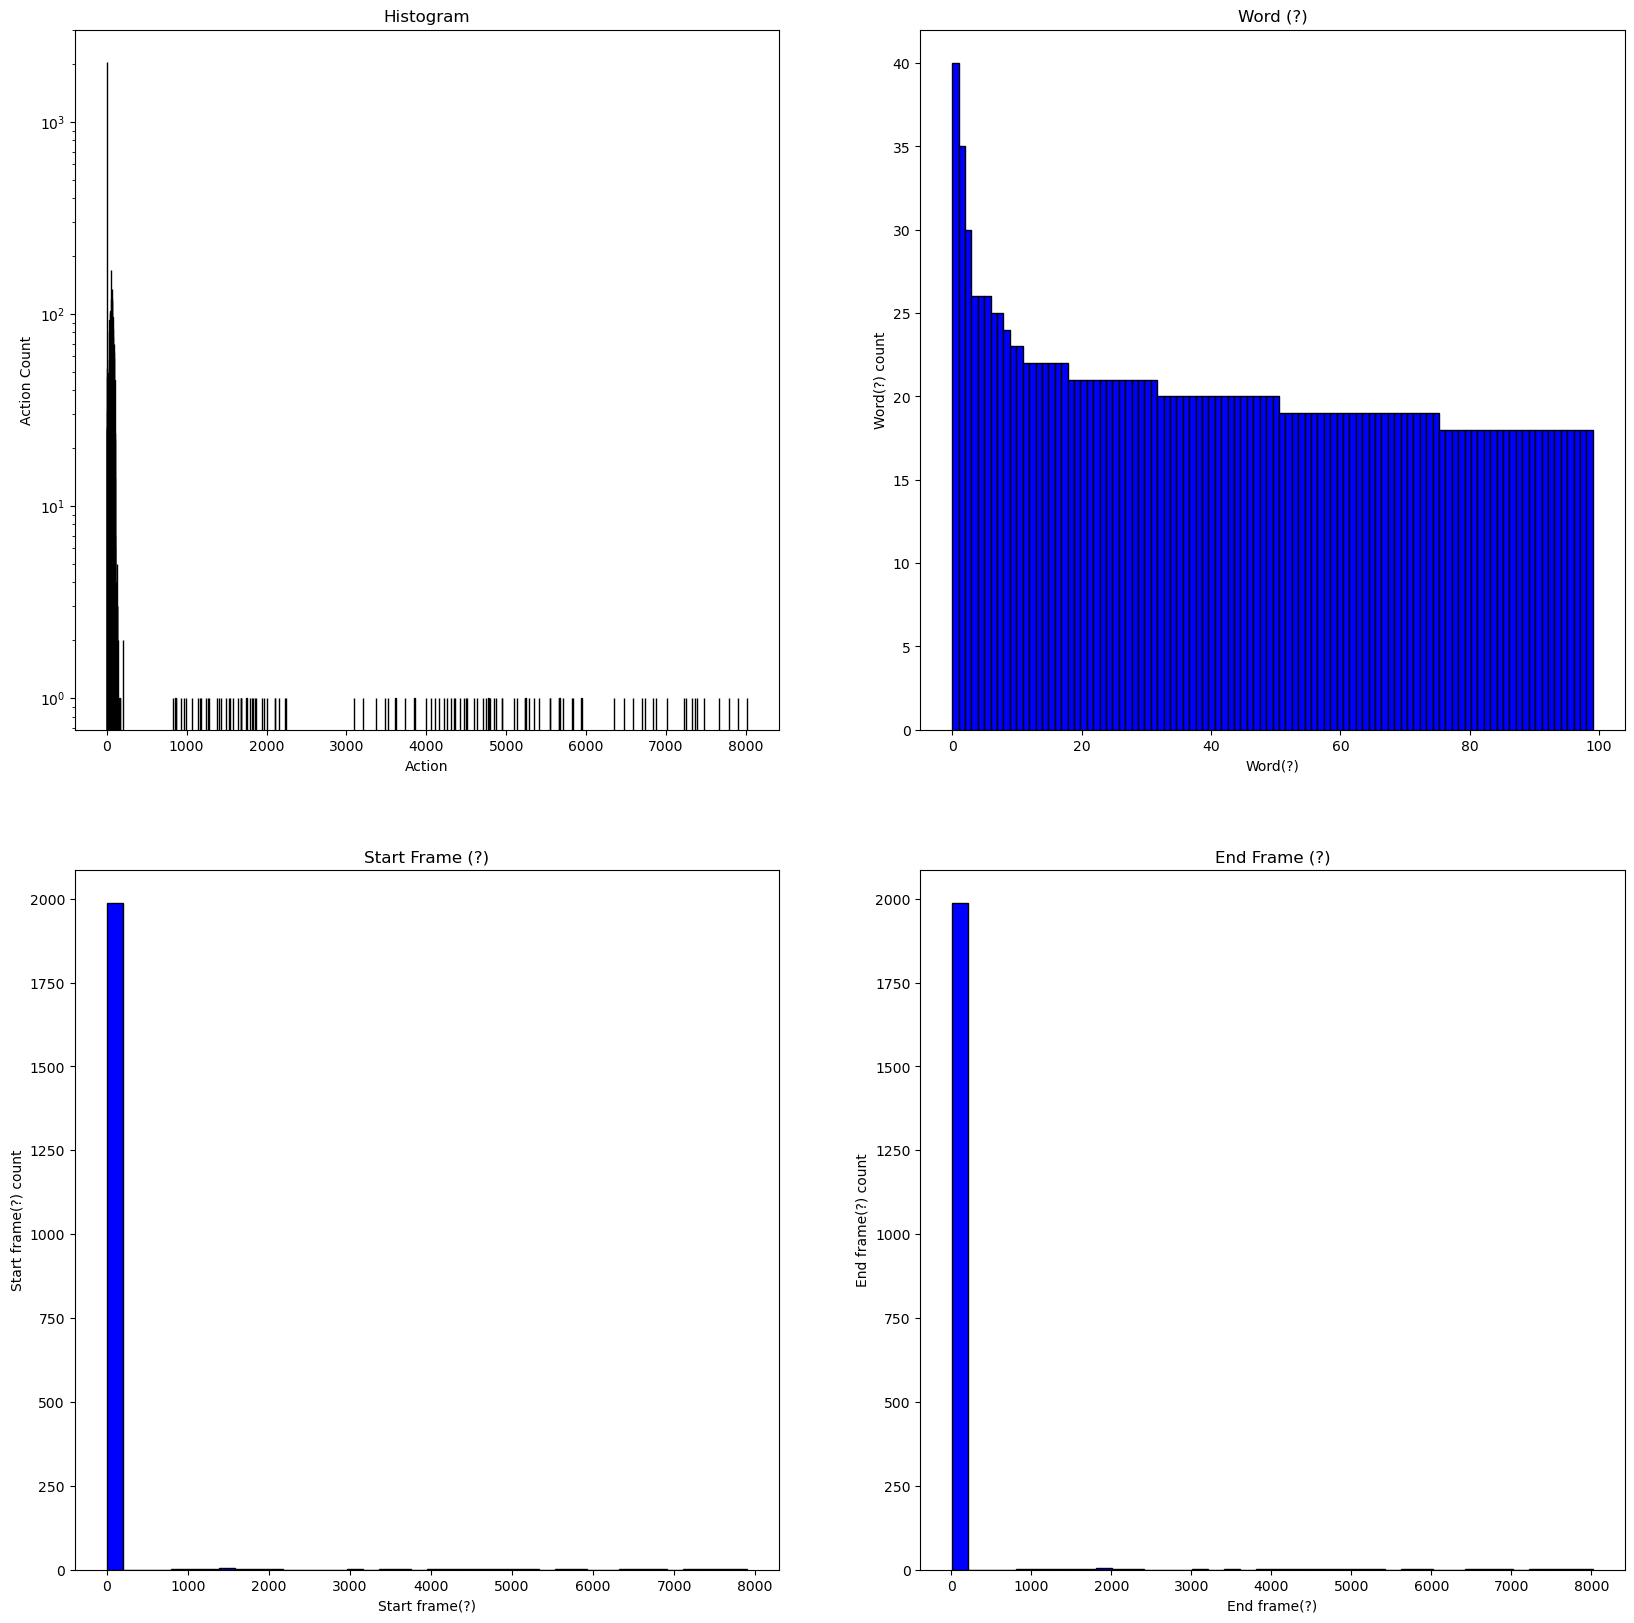

In [4]:
print(f"number of unique actions : {len(np.unique(actions))}")
print(f"number of unique action length : {len(np.unique(action_lengths))}")
print(f"number of unique prop1 : {len(np.unique(prop1))}")
print(f"number of unique prop2 : {len(np.unique(prop2))}")
print(f"number of unique prop3 : {len(np.unique(prop3))}")

plt.figure(figsize=(20,20))
plt.subplot(2, 2, 1)
# Plot histogram
plt.hist(actions, bins=len(actions), edgecolor='black', color='blue')
# Add labels and title
plt.xlabel('Action')
plt.ylabel('Action Count')
plt.title('Histogram')
plt.yscale("log")

plt.subplot(2, 2, 2)
# Plot histogram
plt.hist(prop1, bins=100, edgecolor='black', color='blue')
# Add labels and title
plt.xlabel('Word(?)')
plt.ylabel('Word(?) count')
plt.title('Word (?)')

plt.subplot(2, 2, 3)
# Plot histogram
plt.hist(prop2, bins=40, edgecolor='black', color='blue')
# Add labels and title
plt.xlabel('Start frame(?)')
plt.ylabel('Start frame(?) count')
plt.title('Start Frame (?)')

plt.subplot(2, 2, 4)
# Plot histogram
plt.hist(prop3, bins=40, edgecolor='black', color='blue')
# Add labels and title
plt.xlabel('End frame(?)')
plt.ylabel('End frame(?) count')
plt.title('End Frame (?)')

# Show plot
plt.show()

In [5]:
# returns True : strong indication that the first value is word, second is frame start, third is frame end
np.all(prop2 < prop3)

True

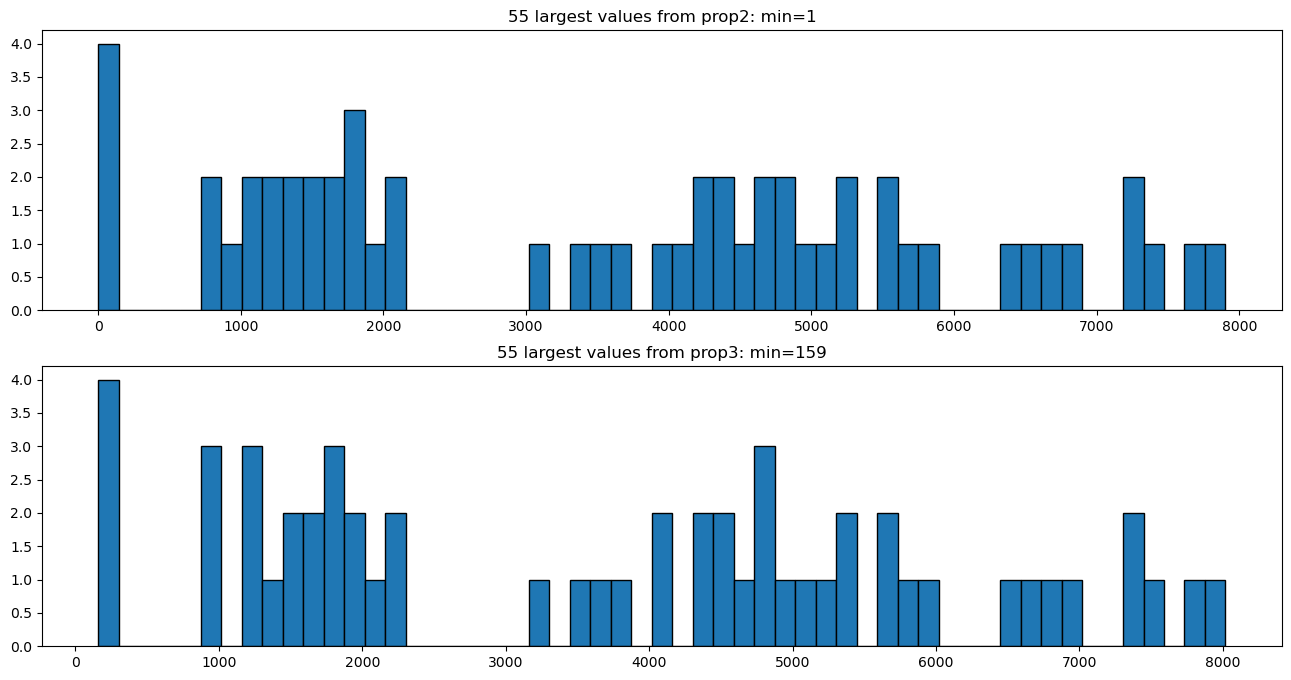

In [6]:
# the dataset contains few points, that their start and end frame is extremely high. 
# they should most likely be removed, as this would indicate very long video
offset = 55

subset_prop2 = sorted(prop2)[-offset:]
subset_prop3 = sorted(prop3)[-offset:]

subset_prop2_min = subset_prop2[0]
subset_prop3_min = subset_prop3[0]

plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.title(f"{offset} largest values from prop2: min={subset_prop2_min}")
plt.hist(subset_prop2, bins=offset, edgecolor="black")

plt.subplot(2, 1, 2)
plt.title(f"{offset} largest values from prop3: min={subset_prop3_min}")
plt.hist(subset_prop3, bins=offset, edgecolor="black")


plt.show()

values left 1981 from 2038 [ 97.203 % of data]
words_filtered unique : 100
start_frames_filtered unique : 1
end_frames_filtered unique : 120


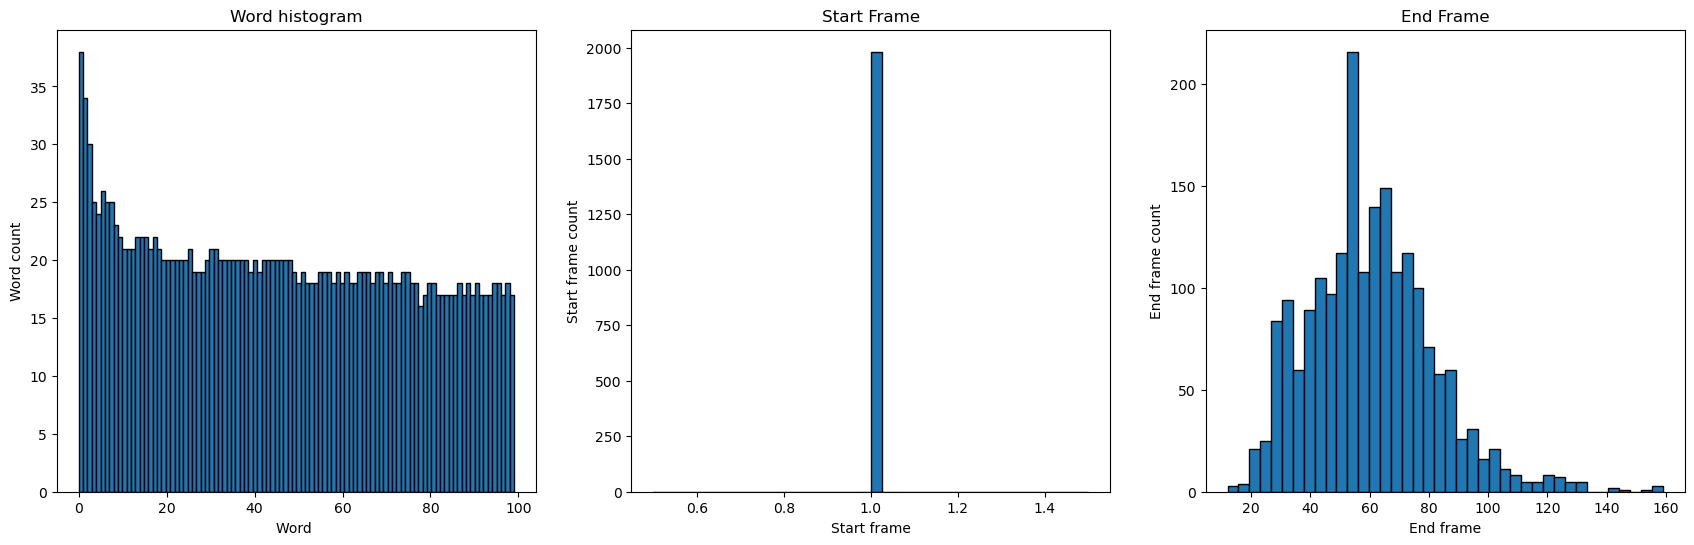

In [7]:
# now let's remove the values, that has extremely high 

# filter by the subset2 
mask = np.logical_and(prop2 <= subset_prop2_min, prop3 <= subset_prop3_min)
print(f"values left {np.sum(mask)} from {len(prop2)} [ {round( 100 * np.sum(mask) / len(prop2) , 3)} % of data]")

words_filtered = prop1[mask]
start_frames_filtered = prop2[mask]
end_frames_filtered = prop3[mask]
video_ids_filtered = np.array(video_ids)[mask]

print(f"words_filtered unique : {len(np.unique(words_filtered))}")
print(f"start_frames_filtered unique : {len(np.unique(start_frames_filtered))}")
print(f"end_frames_filtered unique : {len(np.unique(end_frames_filtered))}")

plt.figure(figsize=(21,6))
plt.subplot(1, 3, 1)
# Plot histogram
plt.hist(words_filtered, bins=100, edgecolor='black')
# Add labels and title
plt.xlabel('Word ')
plt.ylabel('Word count')
plt.title('Word histogram')

plt.subplot(1, 3, 2)
# Plot histogram
plt.hist(start_frames_filtered, bins=40, edgecolor='black')
# Add labels and title
plt.xlabel('Start frame')
plt.ylabel('Start frame count')
plt.title('Start Frame')

plt.subplot(1, 3, 3)
# Plot histogram
plt.hist(end_frames_filtered, bins=40, edgecolor='black')
# Add labels and title
plt.xlabel('End frame')
plt.ylabel('End frame count')
plt.title('End Frame')

# Show plot
plt.show()

## Make sure that the videos exists

In [8]:
from typing import List

#words_filtered = prop1[mask]
#start_frames_filtered = prop2[mask]
#end_frames_filtered = prop3[mask]
#video_ids_filtered = np.array(video_ids)[mask]

def process_video_from_path(path : str) -> List[np.ndarray]:
    if not os.path.exists(path):
        return None
    
    return []
    #print(os.path.exists(path))

found_words = []
found_starts = []
found_ends = []
found_ids = []
    
cnt = 0
not_found = []
for i in tqdm(range(len(video_ids_filtered))):
    pth = os.path.join(video_path, video_ids_filtered[i] + ".mp4")
    res = process_video_from_path(pth)
    if res is not None:
        cnt += 1
        found_ids.append(pth)
        found_words.append(words_filtered[i])
        found_starts.append(start_frames_filtered[i])
        found_ends.append(end_frames_filtered[i])
    else:
        not_found.append(pth)
        
found_words = np.array(found_words)
found_starts = np.array(found_starts)
found_ends = np.array(found_ends)
found_ids = np.array(found_ids)

print(f"{len(found_ids)}/{len(video_ids)}")

100%|██████████| 1981/1981 [00:00<00:00, 13472.64it/s]

1011/2038


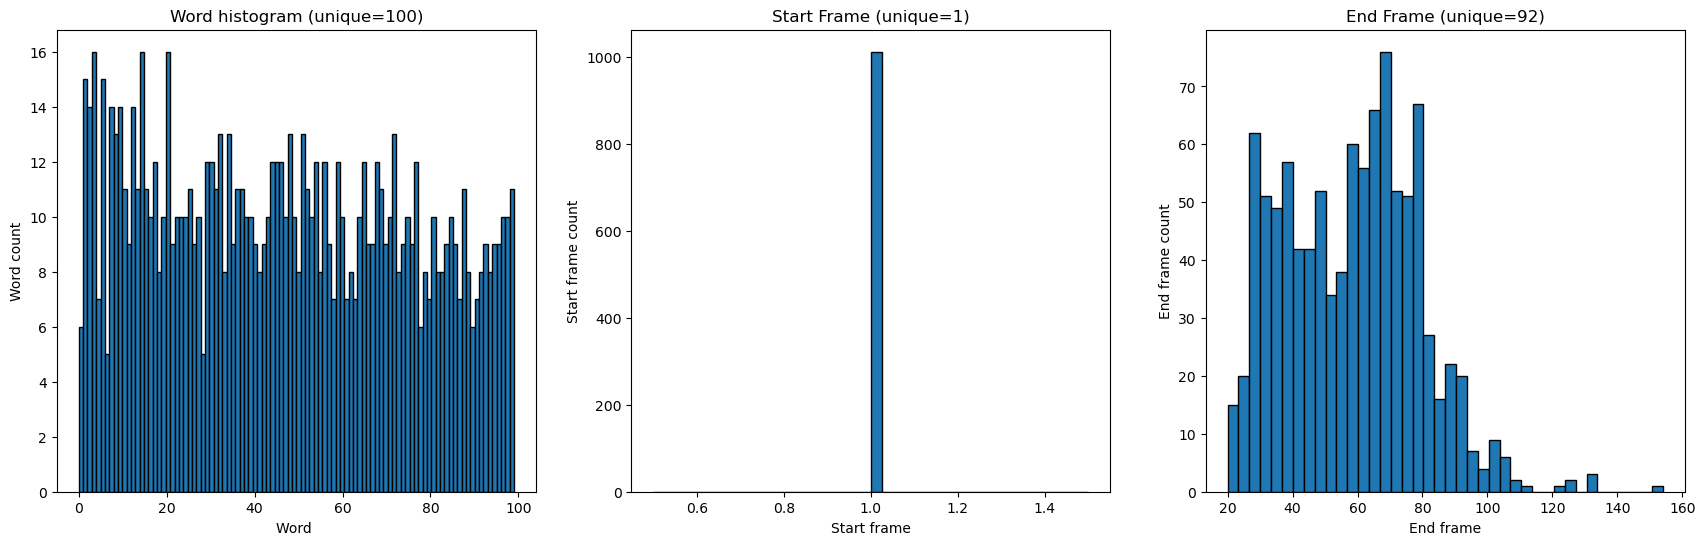

In [9]:
plt.figure(figsize=(21,6))
plt.subplot(1, 3, 1)
# Plot histogram
plt.hist(found_words, bins=100, edgecolor='black')
# Add labels and title
plt.xlabel('Word ')
plt.ylabel('Word count')
plt.title(f'Word histogram (unique={len(np.unique(found_words))})')

plt.subplot(1, 3, 2)
# Plot histogram
plt.hist(found_starts, bins=40, edgecolor='black')
# Add labels and title
plt.xlabel('Start frame')
plt.ylabel('Start frame count')
plt.title(f'Start Frame (unique={len(np.unique(found_starts))})')

plt.subplot(1, 3, 3)
# Plot histogram
plt.hist(found_ends, bins=40, edgecolor='black')
# Add labels and title
plt.xlabel('End frame')
plt.ylabel('End frame count')
plt.title(f'End Frame (unique={len(np.unique(found_ends))})')

# Show plot
plt.show()

## See some of the videos

In [10]:
import cv2

def get_video(video_path : str) -> List[np.ndarray]:
    if not os.path.exists(video_path):
        return None
    
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return None

    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            frame_array = np.array(frame)
            frames.append(cv2.cvtColor(frame_array, cv2.COLOR_BGR2RGB))
        else:
            break

    cap.release()

    return np.array(frames)



In [11]:
def visualize_video(frames, save_path=None, mult=2, show=True):

    # load the frame 
    # frames = get_video(found_ids[0])

    # calculate the grid
    image_cnt = frames.shape[0]
    rounded_cnt = ceil(sqrt(image_cnt))

    # calculate the width/height ratio
    ratio = frames.shape[1] / frames.shape[2]

    # create grid of arrays
    fig, axs = plt.subplots(rounded_cnt, rounded_cnt, figsize=( rounded_cnt*mult, ratio * rounded_cnt*mult))
    axs_flat = axs.flatten()

    # Loop through images and display each
    for i in range(rounded_cnt * rounded_cnt):
        if i < len(frames):
            axs_flat[i].imshow(frames[i])
        axs_flat[i].axis('off')  # Turn off axis
        axs_flat[i].set_title(i)

    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')        
    
    if show:
        plt.show()
    else:
        plt.close()

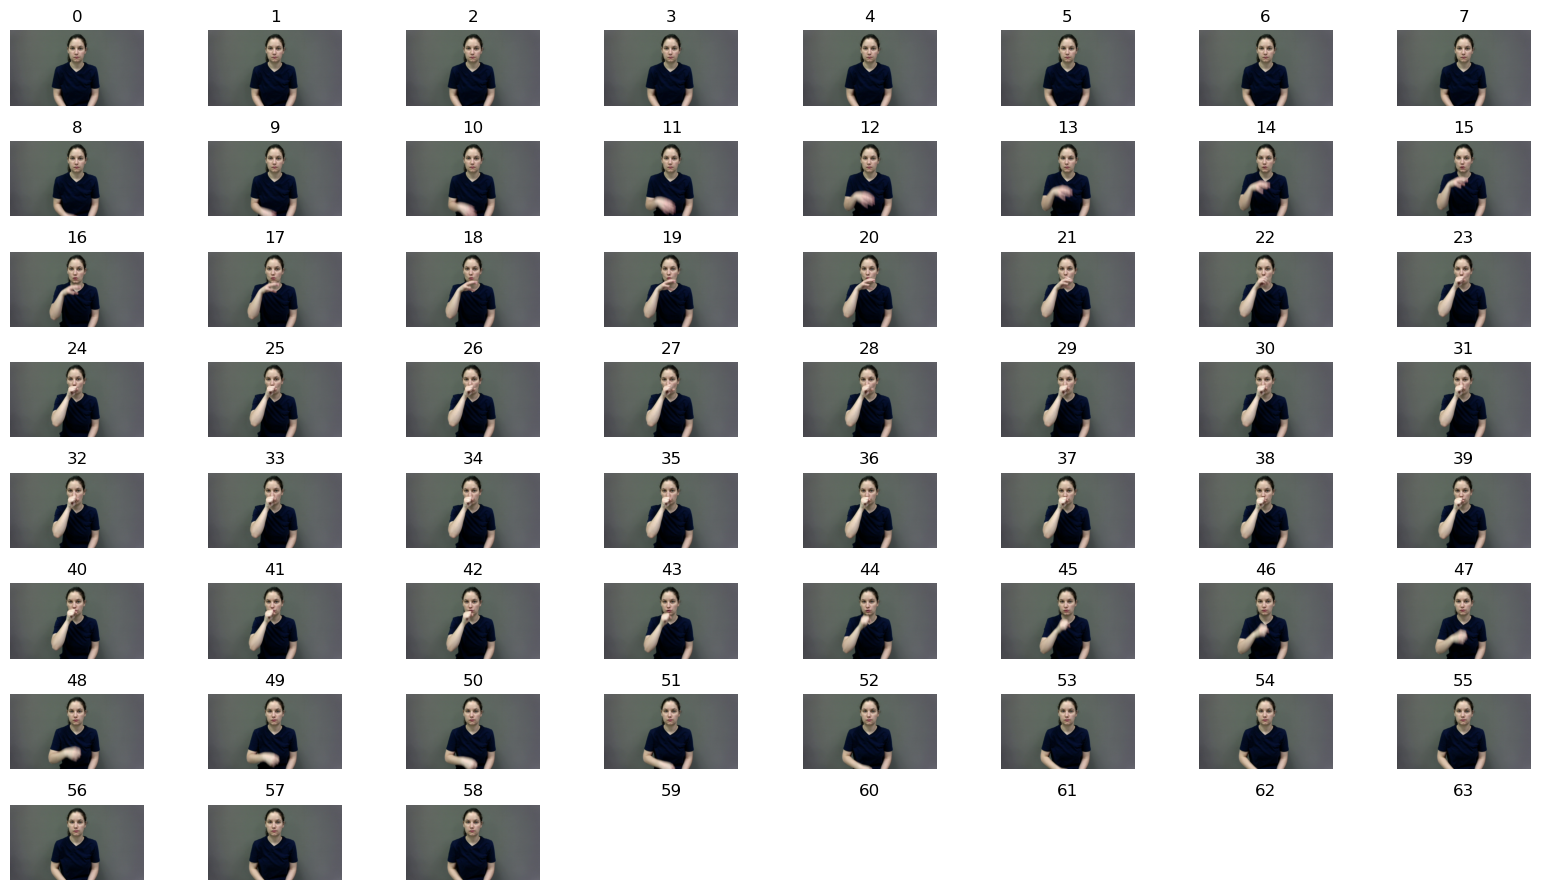

In [12]:
visualize_video(get_video(found_ids[0]), save_path="1.png")

# Create PyTorch dataset

## Regular Dataset : store the data on disk and load it from there

In [23]:
import os 
import torch
import random
import numpy as np
from tqdm import tqdm
from typing import List

import torch
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
        
class SignRecognitionDataset(Dataset):

    def __init__(self, max_start : int, max_end) -> None:
        # setup the paths
        video_path = os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.VIDEO_FOLDER)
        dataset_description = os.path.join(CONFIG.ROOT_DIRECTORY)

        # load the filepaths for videos
        self.video_paths = [os.path.join(video_path, file) for file in os.listdir(video_path)]

        # load the dataset config json
        self.config_json = None
        with open(os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.JSON_FILE)) as f:
            self.config_json = json.load(f)

        # load the dataset json
        self.dataset_json = None
        with open(os.path.join(CONFIG.ROOT_DIRECTORY, CONFIG.NSLT_FILE)) as f:
            self.dataset_json = json.load(f)
        
        self.videos_paths = []
        self.paths_not_found = []
        self.labels = []
        self.start_frames = []
        self.end_frames = []
        

        for el in tqdm(dataset_json.items()):
            video_id, properties = el[0], el[1]
            path = os.path.join(video_path, video_id + ".mp4")
            
            if not os.path.exists(path):
                self.paths_not_found.append(path)
                continue

            subset = properties["subset"]
            label, start, end = properties["action"]
            
            if start > max_start:
                continue
                
            if end > max_end:
                continue
            
            self.videos_paths.append(path)
            self.labels.append(label)
            self.start_frames.append(start)
            self.end_frames.append(end)
    
        self.videos_paths = np.array(self.video_paths)
        self.paths_not_found = np.array(self.paths_not_found)
        self.labels = np.array(self.labels)
        self.start_frames = np.array(self.start_frames)
        self.end_frames = np.array(self.end_frames)
        
    
    def preprocess_trajectory(self, traj : List[np.ndarray]):
        return traj
    
    def __len__(self):
        return len(self.videos_paths)

    def __getitem__(self, idx):
        path, label = self.videos_paths[idx], self.labels[idx]
        trajectory = SignRecognitionDataset.get_video(path)
        
        return self.preprocess_trajectory(trajectory), label
        
        
    @staticmethod
    def get_video(video_path : str) -> List[np.ndarray]:

        if not os.path.exists(video_path):
            return None

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return None

        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if ret:
                frame_array = np.array(frame)
                frames.append(cv2.cvtColor(frame_array, cv2.COLOR_BGR2RGB))
            else:
                break

        cap.release()
        return np.array(frames)

    @staticmethod
    def rescale_video(frames : np.ndarray, desired_shape) -> np.ndarray:
        refined = []
        for img in frames: 
            y, x, c = img.shape
            cropped = img[:, (x // 2 - y//2) : (x // 2 + y//2), :]
            scaled = cv2.resize(cropped, desired_shape)
            refined.append(scaled)
    
        return np.array(refined)
        
    
ds = SignRecognitionDataset(max_start=1, max_end=150)
print(f"after filtering : size of dataset={len(ds)}")

100%|██████████| 2038/2038 [00:00<00:00, 18637.53it/s]

after filtering : size of dataset=11980


In [14]:
"""
framelengths, widths, heights, sizes = [], [], [], []
wh_pairs = []

for x,y in tqdm(ds):
    sh = x.shape
    framelengths.append(sh[0])
    widths.append(sh[1])
    heights.append(sh[2])
    wh_pairs.append((sh[1], sh[2]))
    sizes.append(x.nbytes)
    
from collections import Counter

Counter(wh_pairs)
"""

'\nframelengths, widths, heights, sizes = [], [], [], []\nwh_pairs = []\n\nfor x,y in tqdm(ds):\n    sh = x.shape\n    framelengths.append(sh[0])\n    widths.append(sh[1])\n    heights.append(sh[2])\n    wh_pairs.append((sh[1], sh[2]))\n    sizes.append(x.nbytes)\n'

In [15]:
def Format(x, rnd_digits=3):
    prefix = ""
    if 1024 <= x < 1024**2:
        prefix = "K"
        x /= 1024
    elif 1024**2 <= x < 1024**3:
        prefix = "M"
        x /= 1024**2
    elif x >= 1024**3:
        prefix = "G"
        x /= 1024**3
    
    return f"{round(x,rnd_digits)}{prefix}B"


In [ ]:
print(f"If cached, the total size would be : {Format(sum(sizes))}")


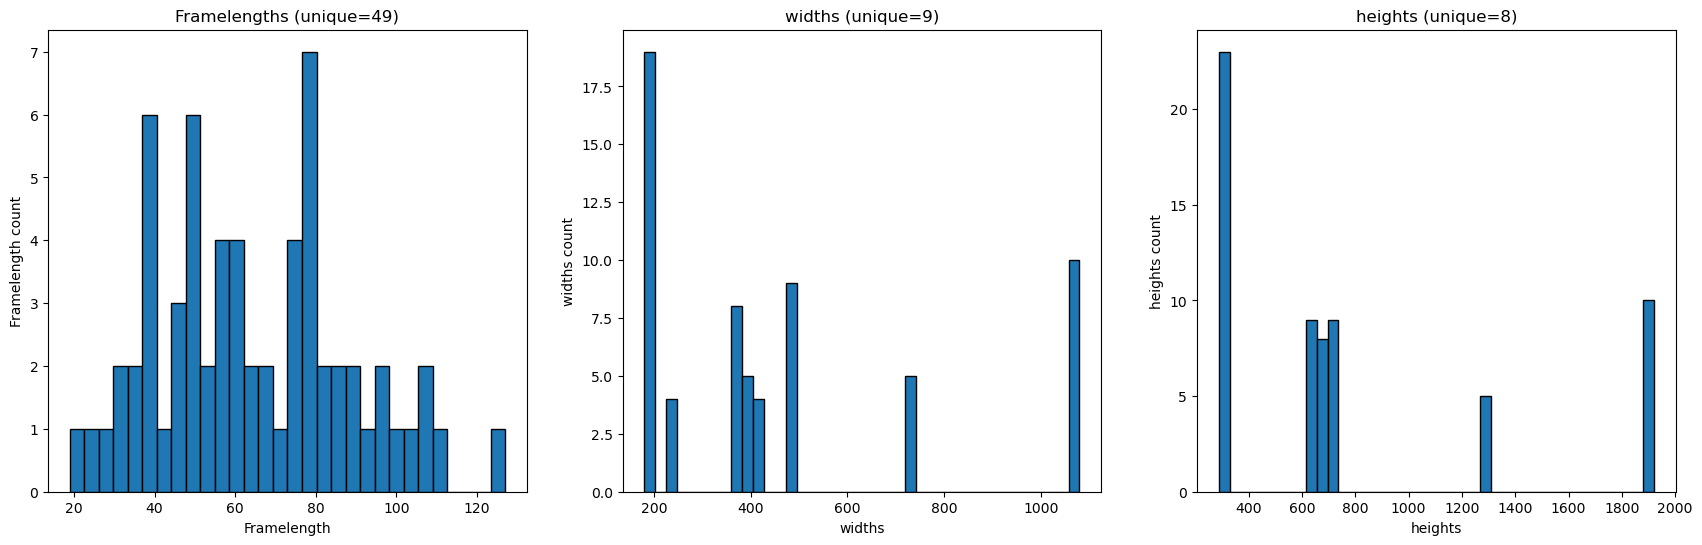

In [17]:
plt.figure(figsize=(21,6))
plt.subplot(1, 3, 1)
# Plot histogram
plt.hist(framelengths, bins=30, edgecolor='black')
# Add labels and title
plt.xlabel('Framelength')
plt.ylabel('Framelength count')
plt.title(f'Framelengths (unique={len(np.unique(framelengths))})')

plt.subplot(1, 3, 2)
# Plot histogram
plt.hist(widths, bins=40, edgecolor='black')
# Add labels and title
plt.xlabel('widths')
plt.ylabel('widths count')
plt.title(f'widths (unique={len(np.unique(widths))})')

plt.subplot(1, 3, 3)
# Plot histogram
plt.hist(heights, bins=40, edgecolor='black')
# Add labels and title
plt.xlabel('heights')
plt.ylabel('heights count')
plt.title(f'heights (unique={len(np.unique(heights))})')

# Show plot
plt.show()

In [34]:
desired_shape = (240, 240)

new_ds = []
sizes_after_rescaling = []
for x,y in tqdm(ds):
    
    refined = []
    for img in x: 
        y, x, c = img.shape
        cropped = img[:, (x // 2 - y//2) : (x // 2 + y//2), :]
        scaled = cv2.resize(cropped, desired_shape)
        refined.append(scaled)

    new_ds.append(np.array(refined))
    sizes_after_rescaling.append((np.array(refined)).nbytes)

100%|██████████| 1010/1010 [03:09<00:00,  5.33it/s]


In [35]:
print(f"after rescaling, the total size would be : {Format(sum(sizes_after_rescaling))}")
np.array(refined).shape

after rescaling, the total size would be : 10.518GB


(79, 240, 240, 3)

## Cached Dataset

In [190]:
from typing import Tuple
from collections import Counter
import albumentations as A
from albumentations.pytorch import ToTensorV2

class SignRecognitionDatasetCached(SignRecognitionDataset):

    def __init__(self, max_start: int, max_end, per_image_transform=None,
                 scaled_resolution : Tuple[int]= (240, 240),
                 frame_size:int=CONFIG.FRAME_SIZE,
                 data_limit : int = CONFIG.DATA_LIMIT,
                 by_size=True) -> None:
        super().__init__(max_start, max_end)
        self.scaled_resolution = scaled_resolution
        self.DATA_LIMIT = data_limit
        self.by_size = by_size
        self.cache_data()
        self.per_image_transform = per_image_transform
        self.FRAME_SIZE = frame_size
        
        self.keywords = ["image" ] + list(str(i) for i in range(frame_size-1))
        
    def preprocess_trajectory(self, traj : List[np.ndarray]):
        return SignRecognitionDataset.rescale_video(traj, self.scaled_resolution)

    def permutate(self):
        l = len(self.videos_paths)
        mask = np.arange(l)
        np.random.shuffle(mask)
        
        self.videos_paths = np.array(self.videos_paths)[mask]
        self.labels = np.array(self.labels)[mask]
        self.start_frames = np.array(self.start_frames)[mask]
        self.end_frames = np.array(self.end_frames)[mask]
        
    def sort_by_size(self):
        c = Counter(self.labels)
        _mask = sorted([ (10000 * c[l] + l, i) for i, l in enumerate(self.labels)])[::-1]
        mask_by_size = np.array([el[1] for el in _mask])

        self.video_paths        = np.array(self.video_paths)[mask_by_size]
        self.labels             = np.array(self.labels)[mask_by_size]
        self.start_frames       = np.array(self.start_frames)[mask_by_size]
        self.end_frames         = np.array(self.end_frames)[mask_by_size]

 
    def cache_data(self):
        if not self.by_size:
            self.permutate()
        else:
            self.sort_by_size()
        
        self.cached_data_x = []
        self.cached_data_y = []
        
        pbar = tqdm(range(self.DATA_LIMIT))
        pbar.set_description("Loading/scaling trajectories")
        for i in pbar:
            trajectory = SignRecognitionDataset.get_video(self.videos_paths[i])            
            trajectory = self.preprocess_trajectory(trajectory)

            self.cached_data_x.append(trajectory)
            self.cached_data_y.append(self.labels[i])
        
        self.unique_labels = np.unique(self.cached_data_y)
        self.label_to_new_id = {self.unique_labels[i] : i for i in range(len(self.unique_labels))}
        self.new_id_to_label = {v : k for k,v in self.label_to_new_id.items()}
        
        for i in range(len(self.cached_data_y)):
            self.cached_data_y[i] = self.label_to_new_id[self.cached_data_y[i]]
        
    def __len__(self):
        return len(self.cached_data_x)

    def crop_video(self, trajectory : np.array) -> np.array:
        cropped = trajectory
        
        if self.FRAME_SIZE != 0:
            frame_size = len(trajectory)
            start = 0 
            
            if frame_size > self.FRAME_SIZE:
                start = np.random.randint(0, frame_size - self.FRAME_SIZE)
            cropped = trajectory[start: (start + self.FRAME_SIZE)]
                    
            if len(cropped) < self.FRAME_SIZE:
                necessary = self.FRAME_SIZE - len(cropped)
                t, h, w, c = trajectory.shape
                cropped = np.concatenate([cropped, np.zeros((necessary, h, w, c))], axis= 0)
                
            return cropped
                        
        return trajectory


    def __getitem__(self, idx):
        trajectory, label = self.crop_video(self.cached_data_x[idx]), self.cached_data_y[idx]

        if self.per_image_transform is not None:            
            frames = {self.keywords[i] : frame for i, frame in enumerate(trajectory)}
            processing = self.per_image_transform(**frames)       

            return torch.stack([processing[kw] for kw in self.keywords]), label    
        return torch.Tensor(trajectory), label
    

transform = A.Compose(
    [
        A.Normalize(mean=CONFIG.mean, std=CONFIG.std),
        A.HorizontalFlip(p=CONFIG.P_OF_TRANSFORM),
        A.ShiftScaleRotate(p=CONFIG.P_OF_TRANSFORM, shift_limit=0.1, scale_limit=0.1, rotate_limit=10),
        #A.RandomBrightnessContrast(p=0.2),
        #A.RGBShift(p=0.2),
        ToTensorV2()
    ],
    additional_targets={str(i) : "image" for i in range(CONFIG.FRAME_SIZE)}
)
    

ds = SignRecognitionDatasetCached(max_start=1, max_end=150,
                                  data_limit=CONFIG.DATA_LIMIT, per_image_transform=transform)

Loading/scaling trajectories: 100%|██████████| 32/32 [00:06<00:00,  4.87it/s]


after filtering : size of dataset=32, found sizes : 1010


gathering labels / iterating through dataset: 100%|██████████| 32/32 [00:01<00:00, 22.49it/s]

Collected 2 unique labels, iterating through dataset took 1.4239 s


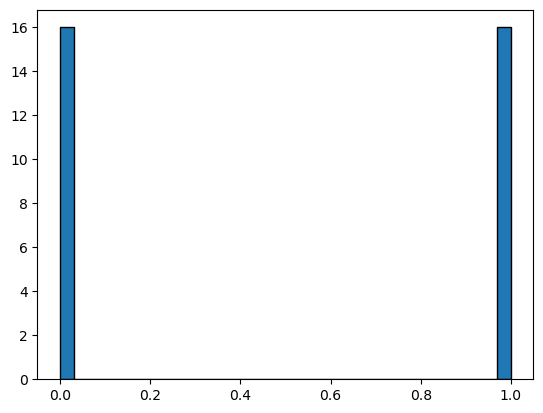

In [191]:
print(f"after filtering : size of dataset={len(ds)}, found sizes : {len(ds.labels)}")
labels, shapes = [], []

pbar = tqdm(ds)
t = time.time()
pbar.set_description("gathering labels / iterating through dataset")

for x, y in pbar:
    shapes.append(x.shape)
    labels.append(y)

print(f"Collected {len(np.unique(labels))} unique labels, iterating through dataset took {round(time.time() - t, 4)} s")

plt.hist(labels, bins=len(labels), edgecolor='black')
plt.show()

  3%|▎         | 1/32 [00:03<01:49,  3.52s/it]
Exception ignored in: <function tqdm.__del__ at 0x00000232855EA020>
Traceback (most recent call last):
  File "D:\Anaconda\Lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "D:\Anaconda\Lib\site-packages\tqdm\std.py", line 1262, in close
    def close(self):

KeyboardInterrupt: 

KeyboardInterrupt



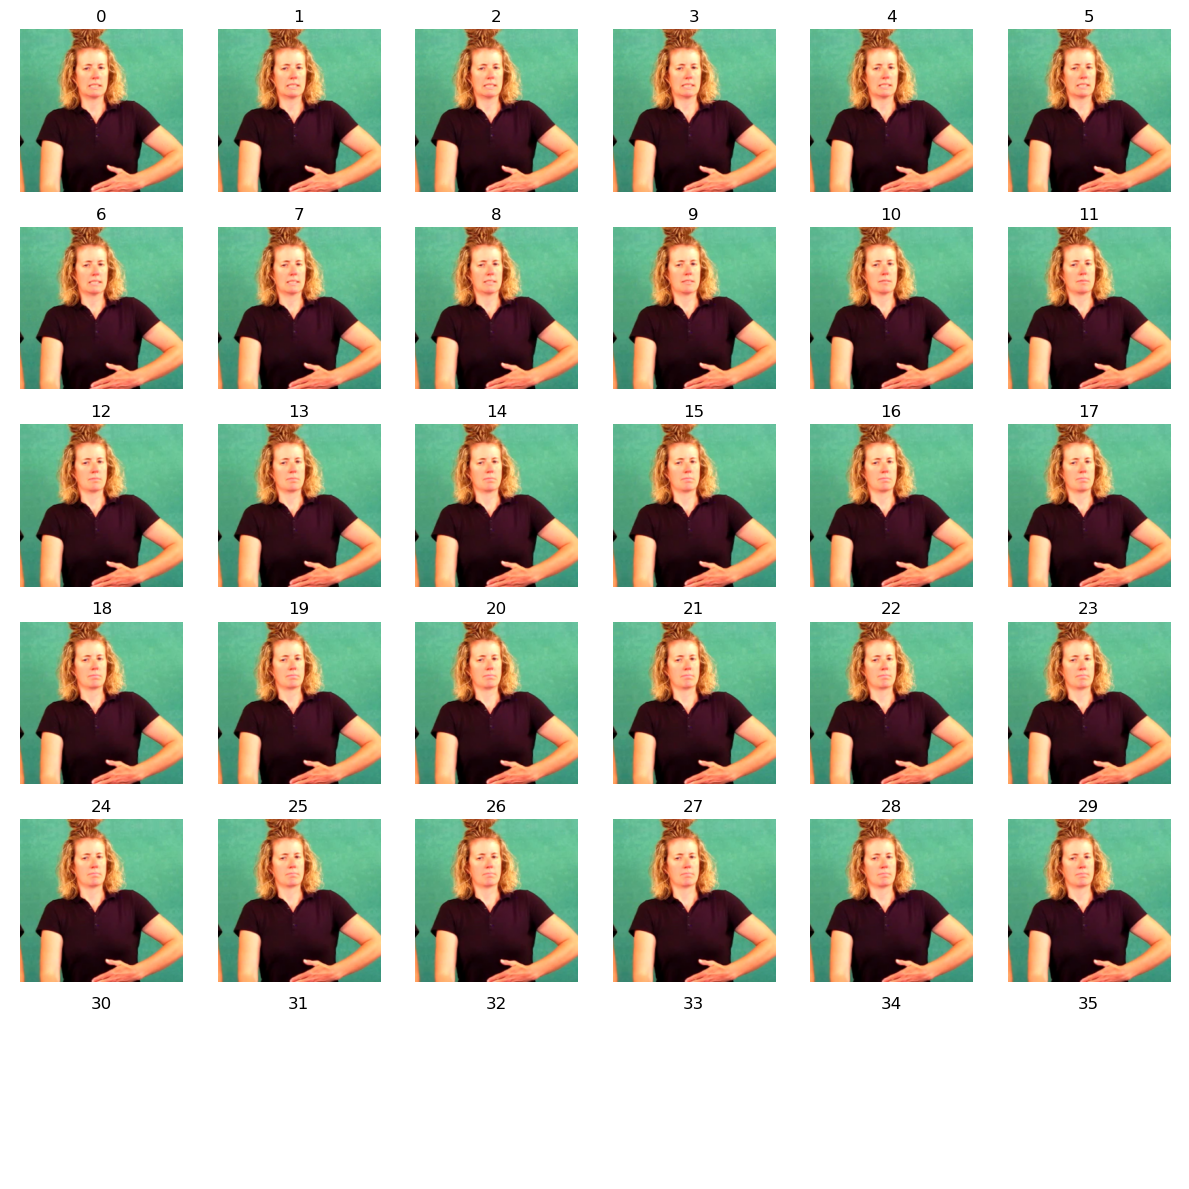

In [192]:
if CONFIG.DEBUG:
    for v in range(2):
        pbar = tqdm(ds)
        for i, (x, y) in enumerate(pbar):
            visualize_video(np.array(x).transpose(0, 2, 3, 1), show=False, save_path=os.path.join("debug_img", f"{v * len(ds) + i}.png"))


# Training 

In [203]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(ds, batch_size=3, shuffle=True)
x, y = next(iter(train_dataloader))
print(x.shape)
print(ds.unique_labels)

torch.Size([3, 30, 3, 240, 240])
[14 20]


In [212]:
class Model(nn.Module):
    def __init__(self, num_classes, hid_size):
        super().__init__() 
        self.backbone = torchvision.models.resnet18()
        self.backbone.fc = nn.Identity() 
        self.lstm = nn.LSTM(input_size=512, hidden_size=hid_size, num_layers=1, batch_first=True)
        self.num_classes = num_classes

        # Classifier layer
        self.fc = nn.Linear(hid_size, num_classes)

        
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        # assumed that the data is in format (batch, time, channels, height, width)
        batch_size, frames, C, H, W = x.size()

        x = x.view(batch_size * frames, C, H, W)

        # Extract features for each frame using ResNet
        # TODO: calculate gradient or not for backbone ? 
        with torch.no_grad(): 
            features = self.backbone(x)            
        
        features = features.view(batch_size, frames, -1)        
        x, _ = self.lstm(features)

        # Take the output of the last time step
        x = x[:, -1, :]
        
        return self.fc(x)
    
m = Model(hid_size=64, num_classes=len(ds.unique_labels))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(m.parameters(), lr=3e-4)

# Example training loop
for epoch in range(10):  # Loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    samples = 0
    
    for i, data in enumerate(train_dataloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = m(inputs)
        loss = criterion(outputs, torch.tensor(labels, dtype=torch.long))
        loss.backward()
        optimizer.step()
        
        # print(outputs)
        
        pred_class = torch.argmax(outputs, dim=1)
        correct += torch.sum(pred_class == labels).item()
        samples += labels.shape[0]
        
        running_loss += loss.item()
        if i % 10 == 9:  # Print every 10 mini-batches
            print(f'[epoch = {epoch + 1}, iteration={i + 1}] loss: {running_loss / 10:.3f} accuracy = {round( correct / samples , 3)}')
            running_loss = 0.0
            correct = 0
            samples = 0


C:\Users\mlewand\AppData\Local\Temp\ipykernel_9512\25650842.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(labels, dtype=torch.long))


[epoch = 1, iteration=10] loss: 0.724 accuracy = 0.333
[epoch = 2, iteration=10] loss: 0.745 accuracy = 0.4
[epoch = 3, iteration=10] loss: 0.696 accuracy = 0.467
[epoch = 4, iteration=10] loss: 0.704 accuracy = 0.467
[epoch = 5, iteration=10] loss: 0.713 accuracy = 0.433
[epoch = 6, iteration=10] loss: 0.699 accuracy = 0.5
[epoch = 7, iteration=10] loss: 0.691 accuracy = 0.533
[epoch = 8, iteration=10] loss: 0.693 accuracy = 0.467
[epoch = 9, iteration=10] loss: 0.692 accuracy = 0.467
[epoch = 10, iteration=10] loss: 0.665 accuracy = 0.633


In [10]:
import torchvision
import torchinfo
import torch.nn as nn

m =torchvision.models.resnet18()
m.fc = nn.Linear(512, 5)
torchinfo.summary(m, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 5]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [8]:
m.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
import 